# Visión por Computador - Práctica 2
## Detección de puntos relevantes y Construcción de panoramas

### 1. Detección de puntos Harris multiescala (MOPS, Brown, Szeliski, Winder, 2004). 

#### En este apartado se trata de implementar el detector de regiones descrito en el artículo mencionado. En este algoritmo se suponen que todas las imágenes están tomadas en una escala semejante (zoom y distancia iguales) por lo que el objetivo es extraer todas las regiones relevantes que haya a distintas escalas enteras de las imágenes. Por cada región detectada necesitaremos guardar la siguiente información: (las coordenadas x ,y de su centro, su orientación, su escala)). Usar para ello la estructura que resulte más fácil. Presentar los resultados con las imágenes Yosemite.rar.

##### a) Escribir una función que extraiga la lista potencial de puntos Harris en una imagen a distintas escalas. Para ello construiremos una pirámide Gaussiana de la imagen con 3 escalas usando $\sigma = 1$. Sobre cada nivel de la pirámide usar la función OpenCV cornerEigenValsAndVecs para extraer los mapas de auto-valores de la matriz Harris en cada píxel (( fijar los valores de blockSize en el rango [3-13] y ksize en el rango [3-9]) , usar la versión de nivel de gris de las imágenes). Crear una matriz con el valor del criterio selección Harris asociado a cada píxel usando ($k=0.04$). Implementar la fase de supresión de valores non-máximos sobre dicha matriz. Ordenar de mayor-a-menor en cada escala los puntos resultantes de acuerdo a su valor Harris. Seleccionar al menos 1500 puntos de entre los de mayor valor distribuidos entre las distintas escalas (las escalas más bajas tendrán más puntos: 70-20-10). Mostrar el resultado dibujando un círculo sobre la imagen original de radio proporcional a la escala y centro las coordenadas de los puntos.

##### b) Extraer los valores (x,y, escala) de los puntos resultantes en el apartado anterior en un vector y refinar su posición espacial a nivel sub-píxel usando la función OpenCV usando cornerSubPix()) con la imagen del nivel de pirámide correspondiente. Actualizar los datos (x,y ,escala) de cada uno de los puntos encontrados. 

##### c) Calcular la orientación relevante de cada punto Harris, usando un alisamiento fuerte de las derivadas en x e y de las imágenes, en la escala correspondiente, como propone el paper MOPS de Brown&Szeliski&Winder. (Apartado 2.5) y añadir la información del ángulo al vector de información del punto. Pintar sobre la imagen de círculos anterior un radio en cada círculo indicando la orientación estimada en ese punto.

- **Apartado a**: para resolver este ejercicio, se han desarrollado varias funciones. Iremos explicándolas poco a poco y viendo su desarrollo.
    
    Antes de realizar la pirámide Gaussiana, lo primero es ver si la imagen es divisible entre el número de divisiones que vamos a hacer. Esto se hace para que, una vez encontrado un punto relevante en la escala $S_i$, sea más sencillo recuperar la posición original en la que se encontraba el píxel, tan solo multiplicando tantas veces como se haya reducido la imagen para encontrar ese punto. De esto se encarga la función ```prepare_img_to_harris_points``` que recibe como parámetro la imagen de la que detectaremos los puntos.
    
    Esta función, recibe la imagen, la pasa a escala de grises y añade tantos píxeles como sean necesarios para poder tener una imagen cuyos puntos Harris sean fáciles de recuperar a la escala original.

In [57]:
import math
import cv2
import random
import numpy as np
from functions import *
from matplotlib import pyplot as plt

def show_img_on_jupyter(im):
    if len(im.shape) == 3:
        img = cv2.cvtColor(im.astype(np.uint8), cv2.COLOR_BGR2RGB)
        plt.imshow(img)
    else:
        img = im
        plt.imshow(img, cmap='Greys_r')
    
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()

def prepare_img_to_harris_points(img):
    # Extraemos las dimensiones de la imagen, para que,
    # en caso de que sean de tamaño impar, añadirle las filas
    # o columnas que correspondan, para que, al reducir,
    # podamos recuperar fácilmente las coordenadas de los puntos
    # harris.
    alt, anch = img.shape[:2]

    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    aux=[]
    # Ensanchamos una fila de la imagen
    if alt % 4 != 0 and anch % 4 == 0:
        aux = np.ones(shape=(alt + alt % 4, anch), dtype=np.uint8)
        insert_img_into_other(img_src=gray_img, img_dest=aux, 
                              pixel_left_top_col=0,
                              pixel_left_top_row=0, substitute=True)

    # Ensanchamos una columna de la imagen
    elif alt % 4 == 0 and anch % 4 != 0:
        aux = np.ones(shape=(alt, anch + anch % 4), dtype=np.uint8)
        insert_img_into_other(img_src=gray_img, img_dest=aux, 
                              pixel_left_top_col=0,
                              pixel_left_top_row=0, substitute=True)

    # Ensanchamos una fila y una columna de la imagen
    elif alt % 4 != 0 and anch % 4 != 0:
        aux = np.ones(shape=(alt + alt % 4, anch + anch % 4), dtype=np.uint8)
        insert_img_into_other(img_src=gray_img, img_dest=aux, 
                              pixel_left_top_col=0,
                              pixel_left_top_row=0, substitute=True)
    # se queda igual que la original
    else:
        aux = np.copy(gray_img)

    return aux


  Lo siguiente, es generar la pirámide Gaussiana con la función ```generate_gaussian_pyramide``` definida en la práctica anterior, y obtener los puntos en los que su valor de Harris supere un umbral mínimo. En este caso, el umbral se ha definido con un mínimo de $10^{-6}$ para que haya un gran número de puntos para poder obtener suficientes puntos de calidad.
  
  Para obtener estos puntos, se ha implementado la función ```get_eigenVals_and_eigenVecs```, que recibe como parámetros la pirámide de imágenes de la que se extraerán los puntos, el umbral, el tamaño de bloque (que es el tamaño del vecindario del punto) y el ksize (parámetro para el operador de Sobel). La función tiene un bucle en el que se llama a la función de OpenCV ```cornerEigenValsAndVecs``` que nos devuelve los valores de $\lambda_1$, $\lambda_2$, los autovalores y autovectores de ambos. Con ellos calcularemos la traza y el determinante para cada una de las imágenes para obtener el valor de Harris de cada uno de los píxeles de la función. Este valor lo calcularemos siguiendo el criterio histórico de Harris: $$ f = determinant(M) - \alpha \cdot trace(M)^2 $$ donde $\alpha$ es una constante que usaremos con valor 0.04, representada en el código como $k$. Siguiendo esto, obtendremos los valores de cada punto en la matriz, y almacenaremos los índices de los puntos que superan el umbral. Esto lo repetiremos para cada escala:

In [58]:
# Criterio histórico de Harris
harrisCriterio = lambda det, tr, k=0.04: det - k*(tr**2)

# Obtiene los valores de harris y los indices
# de los puntos que superan el umbral
def get_eigenVals_and_eigenVecs(pyramide, thresdhold, blockS, kSize):
    eingen_vals_and_vecs = []
    strong_values = []

    for im in pyramide:
        # Obtenemos la matriz de con los autovalores de la matriz
        # y los respectivos autovectores para cada uno de los autovalores
        result = cv2.split(cv2.cornerEigenValsAndVecs(src=im.astype(np.uint8),
                                                      blockSize=blockS, 
                                                      ksize=kSize))
        # Calculamos el determinante como el producto de los autovalores
        det = cv2.mulSpectrums(result[0], result[1], flags=cv2.DFT_ROWS)
        # Calculamos la traza como la suma de los autovalores
        trace = result[0] + result[1]
        # Realizamos la función de valoración de Harris
        eingen_vals_and_vecs.append(harrisCriterio(det, trace))
        # Y obtenemos los índices de los píxeles 
        # que sobrepasan el umbral mínimo
        strong_values.append(np.where(eingen_vals_and_vecs[-1] > thresdhold))

    return eingen_vals_and_vecs, strong_values

Tras esto, pasaremos a obtener los puntos que conforman un máximo local dentro de su entorno, en los puntos obtenidos en la función anterior. Para ello, definiremos una serie de funciones que se encargarán de hacer este trabajo. Estas funciones son:
- ```local_maximum```: recibe como parámetro un entorno o vecindario de un punto perteneciente a la matriz con los valores de Harris obtenidos en la función anterior, y comprueba si el valor del centro, es el máximo local.
- ```get_local_maximun```: se encarga de obtener todos los máximos locales de los puntos extraídos, para obtener los puntos de mayor calidad de los que han sobrepasado el umbral. Tras esto, devolvemos las coordenadas de los puntos máximos, junto con su valor de Harris.

In [59]:
# Esta función comprueba si el centro del entorno es
# un máximo local o no
def local_maximun(environment):
    floor = math.floor
    height, width = environment.shape[:2]
    center = environment[floor(width/2),floor(height/2)]
    return center == np.max(environment)


def get_local_maximun(imgs, index_mask, mask_size):
    # obtenemos los índices de los puntos que han sobrepasado
    # el umbral mínimo
    escala = 1
    img = 0
    xy_bests_points = []
    harrisV_bests_points = []
    for i in index_mask:
        # Arrays para almacenar las coordenadas en X y en Y
        coord_x = []
        coord_y = []
        rows = i[0]
        cols = i[1]
        # Extendemos la imagen para poder captar fácilmente
        # los máximos locales de los bordes
        imgaux = extend_image_n_pixels(img_src=imgs[img],
                                       border_type=4,
                                       n_pixels=mask_size)
        # Array para almacenar los máximos locales almacenados
        maxHs = []
        for k in range(len(rows)):
            # Obtenemos las cuatro esquinas de la región a analizar
            left = rows[k]
            right = (rows[k]+mask_size)
            top = cols[k]
            down = (cols[k] + mask_size)
            # Y comprobamos si la región contiene en su centro un máximo local
            if local_maximun(imgaux[left:right, top:down]):
                # si lo es, almacenamos su posición y su valor harris
                coord_x.append(rows[k])
                coord_y.append(cols[k])
                maxHs.append(imgs[img][rows[k],cols[k]])

        # Insertamos los puntos máximos y su valor en la lista
        xy_bests_points.append(np.array([np.array(coord_x), 
                                         np.array(coord_y)]))
        # xy_bests_points.append(maxls_xy)
        harrisV_bests_points.append(maxHs)
        img += 1
        escala *= 2

    return xy_bests_points, harrisV_bests_points


Una vez encontrados los máximos locales, pasamos a encontrar y seleccionar los mejores puntos de cada escala. En la escala más baja (la original) encontraremos el mayor número de puntos, y cada vez que subamos un nivel en la pirámide, seleccionaremos menos, escogiendo el 70%, el 20% y el 10% en cada uno de los niveles respectivamente.

De esto se encarga la función ```get_best_points```, que en cada nivel, ordena los puntos máximos de mayor a menor según su valor de Harris, y selecciona el porcentaje de puntos que queremos de cada nivel.

In [60]:
def get_best_points(img_points, xy_points, harrisV, n_points):
    # Pasamos a poner a 1 los puntos con máximos locales
    it = 0
    floor = math.floor
    # Esto representa el porcentaje de puntos que tomaremos de cada escala
    # tomando del primer nivel el 70%, del segundo el 20% y del último el 10%
    percentages = [.7, .2, .1]
    escala = 1
    selected_points = []
    # Empezamos a recorrer los puntos que hemos extraído como máximos locales
    for points in harrisV:
        # ordenamos los puntos. Como argsort los da ordenados
        # de menor a mayor, invertimos el vector para obtenerlos
        # de mayor a menor.
        index = np.argsort(points)[::-1]
        # tomamos las coordenadas del % de puntos mejores
        coord_xy = [xy_points[it][0][index[0:floor(n_points * percentages[it])]],
                    xy_points[it][1][index[0:floor(n_points * percentages[it])]]]

        # Almacenamos los mejores puntos de cada escala
        # ya ordenados, y sin
        selected_points.append(np.array(coord_xy).T)

        # Almacenamos los puntos en una lista para poder
        # dibujar los círculos
        coordinates_for_circles = [
            xy_points[it][1][index[0:floor(n_points * percentages[it])]] * escala,
            xy_points[it][0][index[0:floor(n_points * percentages[it])]] * escala,
        ]
        # coordinates_for_circles.append(coord_xy*escala)
        # y los ponemos a 1
        img_points[coordinates_for_circles[::-1]] = 255
        it += 1
        escala *= 2

    show_img_on_jupyter(img_points)

    return selected_points

* **Apartado b**: una vez que tenemos los mejores puntos de cada nivel, pasamos a refinar estos puntos a nivel de subpíxel. Para ello, implementaremos la función ```refine_points```, que recibe como parámetros la pirámide de imágenes, y los puntos seleccionados. 
    Para cada punto de cada nivel, se refina a nivel de subpíxel llamando a la función de *OpenCV* ```cornerSubPix```, almacenándolo en una lista multinivel los puntos que hemos refinado.

In [61]:
def refine_points(pyramide, selected_points):
    refined_points = []
    it = 0

    for img in pyramide:
        float_esquinas = np.array(selected_points[it], dtype=np.float32).copy()
        cv2.cornerSubPix(image=img.astype(np.float32), corners=float_esquinas,
                         winSize=(5, 5), zeroZone=(-1, -1),
                         criteria=(cv2.TERM_CRITERIA_MAX_ITER | 
                                   cv2.TERM_CRITERIA_COUNT, 10, 0.01))
        it += 1
        refined_points.append(float_esquinas)

    return refined_points

* **Apartado c**: una vez refinados los píxeles a nivel de subpíxel, pasamos a obtener la dirección estimada del gradiente en ese punto. Para ello, derivamos la imagen en $\mathcal{X}$ y en $\mathcal{Y}$. Una vez derivada la imagen, para obtener el ángulo, realizamos lo siguiente: $$\arctan\left(\frac{dy}{dx}\right)$$

    Una vez hecho esto, el ángulo tendremos que convertirlo de radianes a grados para trabajar con OpenCV, multiplicando por 180 y dividiendo por $\pi$. Tras esto almacenamos los puntos en una lista.

In [62]:
def detect_angles(pyramide, refined_points):
    # inicializamos la lista con los ángulos
    angles = []
    # y recorremos las tres escalas
    for scale in range(3):
        dx_img, dy_img = get_derivates_of(img=pyramide[scale], sigma=4.5)
        # Obtenemos los indices para poder
        indices = np.array(refined_points[scale].T, dtype=int)
        # Calculamos los ángulos de forma vectorizada, donde
        # el ángulo es:
        #           ang = atan( dy/dx )
        angles.append((np.arctan2(dy_img[indices[0], indices[1]],
                                  dx_img[indices[0], indices[1]]))*180/np.pi)

    # Devolvemos los ángulos
    return angles

Tras esto, solo nos queda presentar si se desea el resultado obtenido, y devolverlo. Para presentarlo, se ha definido la siguiente función, ```show_result```, que recibe como parámetros la imagen original, los puntos refinados y el ángulo. Para cada uno de las escalas, se usa un radio distinto, donde para los niveles más altos de la pirámide, se usan radios más grandes. A su vez, cambiará el color según las escalas, siendo de color azul la escala original, verde la intermedia y roja la última escala.

In [63]:
def show_result(img, refined_points, angles, thick):
    aux2 = np.copy(img)
    floor = math.floor
    sin = np.sin
    cos = np.cos
    radio = [5, 10, 20]
    colors = [(175, 0, 0), (0, 175, 0), (0, 0, 175)]
    size = 1
    for scale in range(3):
        for i in random.sample(range(len(refined_points[scale])), 100):
        # for i in range(len(refined_points[scale])):
            punto = refined_points[scale][i].astype(np.int) * size
            angle = angles[scale][i]
            cv2.circle(img=aux2, center=(punto[1], punto[0]),
                       radius=radio[scale], color=colors[scale],
                       thickness=thick)
            cv2.arrowedLine(img=aux2, pt1=(punto[1], punto[0]),
                            pt2=(punto[1] + floor(sin(angle) * radio[scale]),
                                 punto[0] + floor(cos(angle) * radio[scale])),
                            color=colors[scale],thickness=thick)
        size *= 2

    show_img_on_jupyter(aux2)

Con todo esto, podemos generar la función ```extract_harris_points``` que recibe como parámetros la imagen de entrada, blockS, kSize, el umbral, el número de puntos que queremos extraer y parámetros para si queremos mostrar los resultados o no, y el grosor de la línea que forma la circunferencia que indica la posición y escala a la que se ha encontrado el punto, y el radio que indica su dirección aproximada.

In [64]:
def extract_harris_points(img, blockS, kSize, thresdhold, 
                          n_points = 1500,
                          show_best_points = True,
                          thick = 1):
    #######################################
    # Apartado a: extrare lista potencial
    # de puntos Harris
    #######################################
    alt, anch = img.shape[:2]
    aux = prepare_img_to_harris_points(img)
    # obtenemos la pirámide gaussiana
    pyramide = generate_gaussian_pyramide(img_src=aux, 
                                          subsample_factor=2, 
                                          n_levels=3)

    # Obtenemos los autovalores y autovectores, junto
    # con los puntos que superan el umbral
    eingen_vals_and_vecs, strong_values = \
        get_eigenVals_and_eigenVecs(pyramide, 
                                    thresdhold, 
                                    blockS, kSize)

    # pasamos a eliminar los no máximos
    xy_points, harrisV = get_local_maximun(imgs=eingen_vals_and_vecs,
                                           index_mask=strong_values,
                                           mask_size=3)
    # inicializamos una imagen binaria (0,255) para
    # representar los máximos locales de la imagen
    img_points = np.zeros(shape=img.shape,dtype=np.uint8)
    # Obtenemos los mejores puntos para cada uno de
    # los niveles

    selected_points = get_best_points(img_points, 
                                      xy_points, 
                                      harrisV, n_points)

    #######################################
    # Apartado b, refinar las coordenadas
    #######################################
    refined_points = refine_points(pyramide, selected_points)

    ####################################
    # Apartado c, detectar orientacion
    ####################################
    # Eliminamos aquellos puntos que puedan haberse excedido del
    # tamaño de la imagen
    refined_points[0] = np.delete(refined_points[0],
                                  np.where(refined_points[0][:, 0] > alt), 0)
    refined_points[0] = np.delete(refined_points[0],
                                  np.where(refined_points[0][0, :] > anch), 0)

    # Obtenemos los ángulos de los gradientes
    angles =  detect_angles(pyramide, refined_points)
    # y mostramos el resultado si procede
    if show_best_points:
        show_result(img, refined_points, angles, thick)

    return refined_points, angles

Para ver el resultado de esta función, podemos lanzar el siguiente ejemplo y ver qué salida produce:

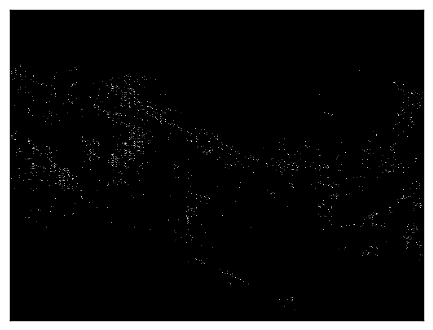

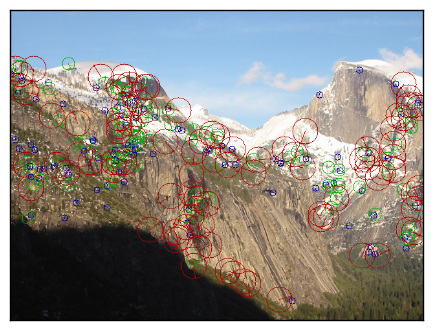

In [65]:
kps, ang = extract_harris_points(cv2.imread('imagenes/yosemite/Yosemite1.jpg', 
                                    flags=cv2.IMREAD_COLOR),
                                 blockS = 3,
                                 kSize = 5, thresdhold=0.000001)

En la primera imagen podemos ver la imagen binaria donde se muestran los puntos que sobrepasan el umbral para el valor de la función de Harris, que son máximos locales en su entorno, mientras que en la segunda imagen, podemos ver algunos de los puntos y la dirección estimada del gradiente. 

En rojo estarán los puntos de la escala donde la imagen es más pequeña, en verde la escala intermedia, y en azul la mayor escala.

### 2.  Detectores KAZE/AKAZE. 

#### Usar los detectores OpenCV (KAZE/AKAZE) sobre las imágenes de Yosemite.rar. Extraer extraer sus listas de keyPoints y establecer las correspondencias existentes entre ellas. Valorar la calidad de los resultados obtenidos bajo el criterio de correspondencias OpenCV “BruteForce+crossCheck".

Para resolver el ejercicio, se ha implementado la función ```AKAZE_descriptor_matcher```, que recibe como parámetros dos imágenes como parámetros obligatorios, y como parámetros opcionales tenemos ```use_KAZE_detector``` para usar KAZE en vez de AKAZE, si queremos pasar una máscara de puntos a los detectores, ```show_matches``` para si queremos mostrar la imagen y el último parámetro, ```sort_points_by_distance_parameter``` ordena las correspondencias según la distancia que exista entre cada par de puntos en la correspondencia.

La función, independientemente del detector escogido, pasa las imágenes a escala de grises, y llama al detector con la función ```detectAndCompute``` que obtiene los keyPoints y sus descriptores en una sola función. 

Tras esto, creamos un *BruteForce matcher* que detectará las correspondencias por fuerza bruta. Tendrá como parámetro ```normType = NORM_L2``` que calcula la distancia euclídea entre dos puntos como medida de error, y además tendrá el parámetro ```crossCheck = True``` para realizar una validación cruzada.

Tras obtener las correspondencias, mostraremos los resultados por pantalla.

In [66]:
def AKAZE_descriptor_matcher(img1, img2, use_KAZE_detector = False,
                             points_mask = None,
                             show_matches = True,
                             sort_points_by_distance_parameter = True):
    # KAZE detector
    if not use_KAZE_detector:
        detector = cv2.AKAZE_create()
    else:
        detector = cv2.KAZE_create()
    # obtenemos las imágenes en blanco y negro
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # detectamos y computamos los keypoints y los descriptores
    # los almacenamos. Estos descriptres serán descriptores SIFT
    keypoints1, descriptors1 = \
        detector.detectAndCompute(image=img1_gray, 
                                  mask=points_mask)
    keypoints2, descriptors2 = \
        detector.detectAndCompute(image=img2_gray, 
                                  mask=points_mask)
    # Creamos el BFmatcher (Brute Force) que usará validación cruzada
    bf = cv2.BFMatcher(normType=cv2.NORM_L2, crossCheck=True)
    # Detectamos las correspondencias o matches
    matches = bf.match(descriptors1,descriptors2)
    # Y las ordenamos según la distancia
    if sort_points_by_distance_parameter:
        matches = sorted(matches, key=lambda x: x.distance)

    if show_matches:
        match_img = cv2.drawMatches(img1 = img1, 
                                    keypoints1=keypoints1,
                                    img2 = img2, 
                                    keypoints2=keypoints2,
                                    matches1to2=matches[:50], 
                                    outImg=None, flags=4)

        show_img_on_jupyter(match_img)
        
    return [keypoints1, descriptors1], [keypoints2, descriptors2], matches

Un ejemplo de uso de esta función podemos verlo a continuación:

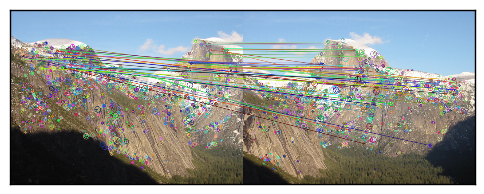

In [67]:
kp1, kp2, matches = AKAZE_descriptor_matcher(
    img1 = cv2.imread('imagenes/yosemite/Yosemite1.jpg', 
                      flags=cv2.IMREAD_COLOR),
    img2 = cv2.imread('imagenes/yosemite/Yosemite2.jpg', 
                      flags=cv2.IMREAD_COLOR),
    sort_points_by_distance_parameter = False)

En esta imagen podemos ver como hay puntos que realizan una correspondencia de calidad, ya que podemos ver cómo van en la misma dirección y siguen un cierto paralelismo en la líneas que marcan las correspondencias. Sin embargo, hay otros puntos, cuya correspondencia es errónea. Esto quiere decir que dentro de las correspondencias que calcula  *BFMatcher*, habrá correspondencias buenas, y correspondencias erróneas.

Además de esto, podemos ordenar los puntos y mostraremos las mejores correspondencias que ha obtenido *BFMatcher*, como podemos ver a continuación.

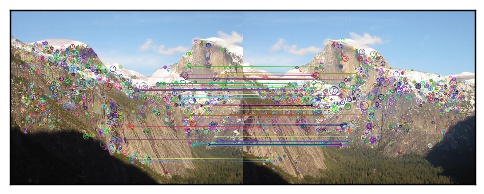

In [75]:
kp1, kp2, matches = AKAZE_descriptor_matcher(
    img1 = cv2.imread('imagenes/yosemite/Yosemite1.jpg', 
                      flags=cv2.IMREAD_COLOR),
    img2 = cv2.imread('imagenes/yosemite/Yosemite2.jpg', 
                      flags=cv2.IMREAD_COLOR),            
    sort_points_by_distance_parameter = True)

Como vemos en este ejemplo, las correspondencias que se muestran son de mucha más calidad que las que se encuentran en el ejemplo anterior.

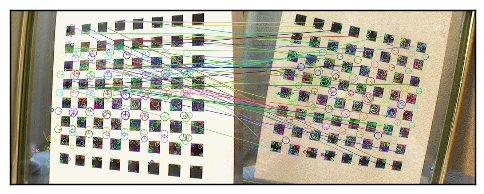

In [69]:
kp1, kp2, matches = AKAZE_descriptor_matcher(
    img1=cv2.imread('imagenes/Tablero1.jpg', 
                    flags=cv2.IMREAD_COLOR),
    img2=cv2.imread('imagenes/Tablero2.jpg',
                    flags=cv2.IMREAD_COLOR),
    sort_points_by_distance_parameter=False)

En esta imagen podemos ver las correspondencias que se han encontrado, y en ellas podemos ver, al igual que en el primer ejemplo, cómo algunas son buenas, y otras, erróneas.

#### Creación de un mosaico de N > 3

##### Escribir una función que forme un Mosaico de calidad a partir de N > 3 imágenes relacionadas por homografías, sus listas de keyPoints calculados de acuerdo al punto anterior y las correspondencias encontradas entre dichas listas. Estimar las homografías entre ellas usando la función ```findHomography(p1,p2,CV_RANSAC,1)```. Para el mosaico será necesario:

###### a) Definir una imagen en la que pintaremos el mosaico.
###### b) Definir la homografía que lleva cada una de las imágenes a la imagen del mosaico.
###### c) Usar la función ```warpPerspective()``` para trasladar cada imagen al mosaico.

Para resolver este ejercicio, se han desarrollado una serie de funciones que son principalmente, ```get_homography```, ```create_two_mosaic``` y ```create_n_mosaic```.
La función ```get_homography``` recibe como parámetros dos imágenes. De ella obtiene las correspondencias entre estas dos imágenes y crea la homografía $H$, usando el criterio de *Ransac*.

In [70]:
def get_homography(img1, img2, n):
    # Obtenemos los puntos clave y descriptores de cada imagen,
    # junto con las correspondencias entre ambas imágenes.
    kp_dsp1, kp_dsp2, matches = AKAZE_descriptor_matcher(
        img1, img2, show_matches=False)
    # Tras esto, obtenemos las coordenadas de los puntos
    # claves de ambas imágenes.
    src_points = \
        np.float32([kp_dsp2[0][point.trainIdx].pt for point in matches][0:n]).reshape(-1, 1, 2)
    dest_points = \
        np.float32([kp_dsp1[0][point.queryIdx].pt for point in matches][0:n]).reshape(-1, 1, 2)
    # Obtenemos la primera homografía y la máscara booleana de puntos buenos
    # que hemos obtenido, para después pasar a "entrenar" o "refinar".
    return cv2.findHomography(src_points,dest_points,cv2.RANSAC,1)

A continuación, pasamos a ver la función ```create_two_mosaic``` que genera un mosaico entre dos imágenes que recibe por parámetros dos imágenes y si deseamos mostrar la o no. 

Esta función obtiene la homografía entre las dos imágenes, y, una vez obtenida, llamamos a la función de *OpenCV* ```warpPerspective```, que aplica la transformación a la imagen que recibe en el segundo parámetro con la homografía, para al final, juntar las dos imágenes en el mismo plano.

In [71]:
def find_not_zero(img, axis):
    if axis == 0:
        i = img.shape[0] - 1
        f = lambda index: np.sum(img[index,:]) != 0
    else:
        i = img.shape[1] - 1
        f = lambda index: np.sum(img[:, index]) != 0

    deleted = True
    while deleted:
        if f(i) != 0:
            deleted = False
        else:
            i -= 1
    return i


def clean_img(img):
    # Eliminamos aquellas columnas en las
    # que los elementos de la matriz son iguales a 0
    return img[0:find_not_zero(img,0), 0:find_not_zero(img,1)]


def create_two_mosaic(img1, img2, n, show = False):

    H, boolean_mask = get_homography(img1, img2, n)

    # Realizamos la transformación a la imagen
    canvas = cv2.warpPerspective(src=img2, M=H,
                                 dsize=(img2.shape[1]+img1.shape[1],
                                        max(img2.shape[0],img1.shape[0])))
    # Y añadimos la otra imagen
    canvas[0:img1.shape[0], 0:img1.shape[1]] = img1
    # Eliminamos los bordes
    canvas = clean_img(canvas)
    # Mostramos si el flag está activo
    if show:
        show_img_on_jupyter(canvas)

    return canvas

Por último, tenemos la función ```create_n_mosaic```, que genera un mosaico para $n$ imágenes que se pasan por parámetro como una lista de estas. Dependiendo de la longitud de la lista, su comportamiento será diferente:
* __Se pasan dos imágenes__: En este caso, se llama a la función ```create_two_mosaic``` para generar directamente el mosaico de ambas imágenes.
* __Se pasan exactamente tres imágenes__: En este caso se obtiene la imagen central de la lista de imágenes, y se compone el mosaico componiendo primero uno con la imagen central y la siguiente, y el resultado con la primera imagen de la lista y el mosaico.
* __Se pasan $n$ imágenes__: Para este último caso, el comportamiento es similar, pero se realiza primero un mosaico para las $\frac{n}{2}$ imágenes del final de la lista, y el resultado se compone con las $\frac{n}{2}$ primeras imágenes de la lista.

In [72]:
def create_n_mosaico(imgs_list, n = 70):
    length = len(imgs_list)
    # Si la longitud es igual a dos, se genera un mosaico
    # de dos imágenes llamando a create_two_mosaic
    if length == 2:
        mosaico = create_two_mosaic(imgs_list[0], imgs_list[1], n)
        
    # Si la longitud es tres, primero creamos un mosaico
    # con la foto central y la derecha, para luego hacer una
    elif length == 3:
        mid = math.floor(len(imgs_list)/2)
        mosaico = create_two_mosaic(imgs_list[mid], imgs_list[mid+1],n)
        mosaico = create_two_mosaic(imgs_list[mid-1], mosaico, n)
    else:
        # En caso de que sean más de 3 imágenes, vamos componiendo el mosaico
        # desde el centro a la derecha, para luego
        # hacerlo del centro a la izquierda
        mid = math.floor(len(imgs_list) / 2)
        mosaico = create_two_mosaic(imgs_list[mid], imgs_list[mid+1], n)
        for i in range(mid+2, length):
            mosaico = create_two_mosaic(mosaico, imgs_list[i],n)
        for i in range(1,mid+1):
            mosaico = create_two_mosaic(imgs_list[mid-i],mosaico,n)
    
    show_img_on_jupyter(mosaico)
    return mosaico

A continuación, podemos varios ejemplos en los que vemos el resultado para estas funciones:

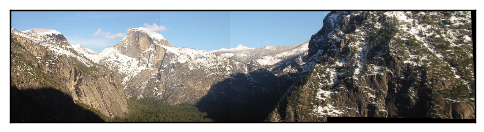

In [73]:
mosaic_yosemite1 = [
        cv2.imread('imagenes/yosemite_full/yosemite1.jpg', flags=cv2.IMREAD_COLOR),
        cv2.imread('imagenes/yosemite_full/yosemite2.jpg', flags=cv2.IMREAD_COLOR),
        cv2.imread('imagenes/yosemite_full/yosemite3.jpg', flags=cv2.IMREAD_COLOR),
        cv2.imread('imagenes/yosemite_full/yosemite4.jpg', flags=cv2.IMREAD_COLOR),
    ]
mosaic1 = create_n_mosaico(mosaic_yosemite1, n = 400)

In [74]:
mosaic_yosemite2 = [
        cv2.imread('imagenes/yosemite_full/yosemite5.jpg', flags=cv2.IMREAD_COLOR),
        cv2.imread('imagenes/yosemite_full/yosemite6.jpg', flags=cv2.IMREAD_COLOR),
        cv2.imread('imagenes/yosemite_full/yosemite7.jpg', flags=cv2.IMREAD_COLOR),
    ]
fx.create_n_mosaico(mosaic_yosemite2, n = 60)

AttributeError: 'function' object has no attribute 'create_n_mosaico'

In [ ]:
mosaic_etsiit = [
        cv2.imread('imagenes/mosaico-1/mosaico002.jpg', flags=cv2.IMREAD_COLOR),
        cv2.imread('imagenes/mosaico-1/mosaico003.jpg', flags=cv2.IMREAD_COLOR),
        cv2.imread('imagenes/mosaico-1/mosaico004.jpg', flags=cv2.IMREAD_COLOR),
        cv2.imread('imagenes/mosaico-1/mosaico005.jpg', flags=cv2.IMREAD_COLOR),
        cv2.imread('imagenes/mosaico-1/mosaico006.jpg', flags=cv2.IMREAD_COLOR),
        cv2.imread('imagenes/mosaico-1/mosaico007.jpg', flags=cv2.IMREAD_COLOR),
        cv2.imread('imagenes/mosaico-1/mosaico008.jpg', flags=cv2.IMREAD_COLOR),
        cv2.imread('imagenes/mosaico-1/mosaico009.jpg', flags=cv2.IMREAD_COLOR),
        cv2.imread('imagenes/mosaico-1/mosaico010.jpg', flags=cv2.IMREAD_COLOR),
        cv2.imread('imagenes/mosaico-1/mosaico011.jpg', flags=cv2.IMREAD_COLOR),
    ]
fx.create_n_mosaico(mosaic_etsiit, n = 100)